# Similarity Matrix and Heat Chart
Data Analysis Python Pandas Data Manipulation Data Visualization Similarity Matrix Heat Chart External Dataset

Suppose you have the following [dataset](https://docs.google.com/spreadsheets/d/1DrvkAWnO1psWkFN1YVt891sHe4yHl4ljNPUVlCsI95M/edit#gid=2039795889)
which contains (1st tab) a list of items purchased by a given user, (2nd tab) a mapping which maps the item_id to the item name and price, (3rd tab) a matrix that formats data from sheet 1 into a matrix with users in rows and the number of each item_id purchased in columns.

Using this data, can you create a similarity matrix for each item? Then can you create a heat chart that visually displays the similarity matrix?

Note: The purpose of doing this exercise is to explore ways of analyzing data that could be generalized by a group (think clustering).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

filename = 'q143_data.csv'
df = pd.read_csv(filename)
df.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [2]:
# 2 steps: 1) break down id1,id2 into 2 rows, then 2) pivot df

# step 1: https://stackoverflow.com/a/28182629
unpivoted_df = (
    pd.DataFrame(
        df['id'].str.split(',').tolist(), 
        index=df['user_id']
    )
    .stack()
    .reset_index()
    .rename(columns={0:'item_id'})
    [['user_id','item_id']]
)
unpivoted_df.head()

,user_id,item_id
0,222087,27
1,222087,26
2,1343649,6
3,1343649,47
4,1343649,17


In [3]:
counts_df = (
    unpivoted_df
    .groupby(['user_id','item_id'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False) # just to show that some users bought the same item multiple times
    .reset_index(drop=True)
)

print('shape:', counts_df.shape)
print('number of item_id:', counts_df[['item_id']].nunique()[0])
print('number of user_id:', counts_df[['user_id']].nunique()[0])
counts_df.head()

shape: (290558, 3)
number of item_id: 48
number of user_id: 24885


,user_id,item_id,counts
0,599172,39,5
1,1198106,45,5
2,917199,18,5
3,920002,23,5
4,269335,2,5


In [4]:
# step 2: pivot
pivoted_df = counts_df.set_index(['user_id','item_id']).unstack(level=-1, fill_value=0)
# column wrangling ...
pivoted_df.columns = pivoted_df.columns.droplevel(0) # remove column multi-index
pivoted_df.columns = [f'item0{i}' if int(i)<10 else f'item{i}' for i in pivoted_df.columns]
pivoted_df = pivoted_df[sorted(pivoted_df.columns)]

# check
assert int(pivoted_df.query('user_id==599172')['item39']) == 5
print('passed')

print(pivoted_df.shape)
pivoted_df.head()


passed
(24885, 48)


,item01,item02,item03,item04,item05,item06,item07,item08,item09,item10,...,item39,item40,item41,item42,item43,item44,item45,item46,item47,item48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


C:\Users\tho\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


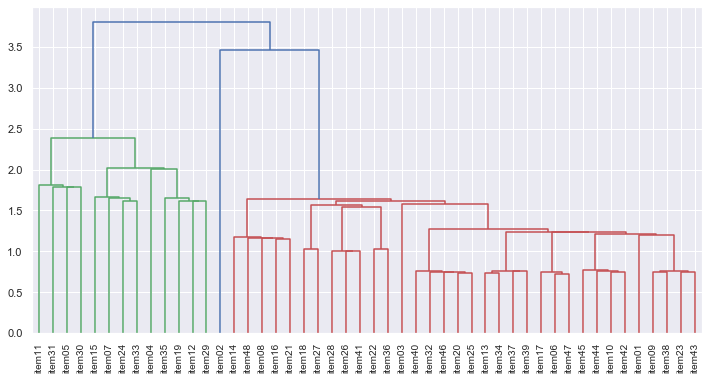

In [5]:
import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dist
import sklearn.metrics.pairwise as pw

# simple intro/example at https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/


def build_sim_matrix(df):
    labels = list(df.index)
    sim = pw.cosine_similarity(df)
    np.fill_diagonal(sim, np.nan)
    return sim, labels
    
    
def build_linkage(sim, method='single'):
    """
    method can single, centroid, median, complete, etc
    see docs for scipy.cluster.hierarchy.linkage
    
    recipe from https://gist.github.com/tommct/c3ffca76251aba2351da7e3b1183bf5a
    """
    distances = 1 - sim # so that 0 is close and 1 is far.
    np.fill_diagonal(distances, 0)
    distances = np.clip(distances, 0, 1)
    dists = dist.squareform(dist.pdist(distances, 'sqeuclidean'))
    links = hc.linkage(dists, method=method)
    return links


def plot_dendrogram(linkage, labels):
    """
    plot dendrogram given the linkage matrix 
    returned by scipy.cluster.hierarchy.linkage
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    dd = hc.dendrogram(linkage, labels=labels, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10)

    
similarity_matrix, labels = build_sim_matrix(pivoted_df.T)
links = build_linkage(similarity_matrix)
plot_dendrogram(links, labels)


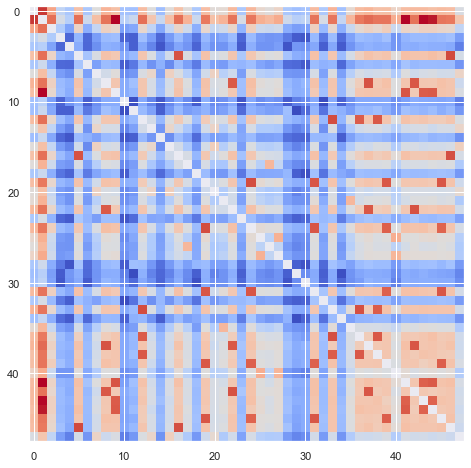

In [6]:
# ugly naive
def plot_sim(sim):
    plt.subplots(1,1,figsize=(8,8))
    plt.imshow(sim, cmap='coolwarm')#, interpolation='nearest')
    plt.show()
    
plot_sim(similarity_matrix) 
# shows there may exist clusters here

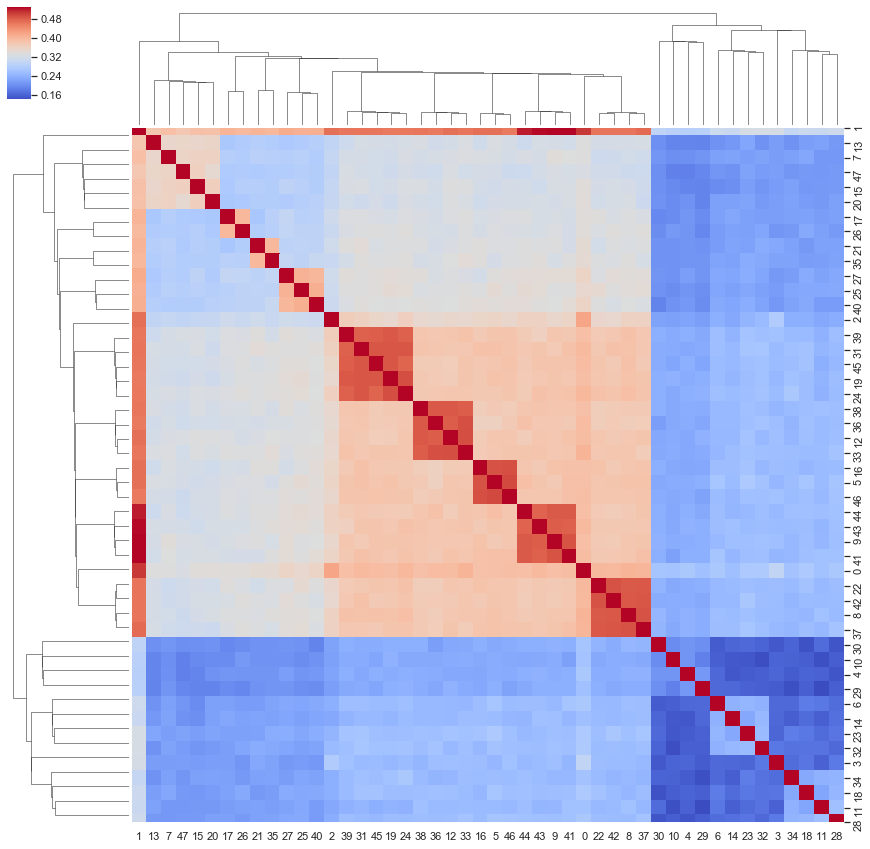

In [7]:

def sns_sim_plot(sim):
    sim = sim.copy()
    # fill diagonal with max value outside diag, so 1 does not skew the range of colors
    np.fill_diagonal(sim, np.nanmax(sim)) 
    g = sns.clustermap(
        sim, 
        method='single',
        figsize=(15,15), 
        cmap='coolwarm'
    )
    
sns_sim_plot(similarity_matrix)

In [9]:
def get_cluster_labels(links, n_clusters):
    """ 
    links: linkage matrix, size n by 4
    n_clusters: integer >= 2
    returns integer array of size n, indicating cluster for this point
    """
    low, high = links[-n_clusters,2], links[-n_clusters+1,2]
    threshold = (low + high)/2
    return hc.fcluster(links, threshold, criterion='distance')

clusters = get_cluster_labels(links, 2)
clusters

array([2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=int32)